In [16]:
%matplotlib inline

In [63]:
import seaborn as sns

In [1]:
import numpy as np
from graph_tool.all import load_graph, GraphView
from graph_tool.topology import kcore_decomposition
from networkit.graphio import readGraph, Format

from brute_force import do_brute_force
from util import complementary_edges


In [2]:
from graph_tool.all import load_graph, sfdp_layout, graph_draw
from graph_tool.topology import kcore_decomposition

In [3]:
g = load_graph('data/karate.gml')

In [4]:
gg = readGraph('data/karate.edgelist', fileformat=Format.EdgeListSpaceOne)
cand_edges = complementary_edges(gg)
optimal_edges = do_brute_force(gg,
                               2, cand_edges)

In [67]:
optimal_edges

{(7, 31), (30, 31)}

In [6]:
core = kcore_decomposition(g)

In [8]:
nodes_c4 = list(np.nonzero(core.a == 4)[0])

In [53]:
subg_nodes = {v for u in nodes_c4 for v in g.get_out_neighbours(u)} | set(nodes_c4)
print(subg_nodes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33}


In [54]:
vfilt = g.new_vertex_property('bool')
for n in subg_nodes:
    vfilt[n] = True
efilt = g.new_edge_property('bool')

# only show edges adjacent to the core-4
for e in g.edges():
    u, v = map(int, [e.source(), e.target()])
    if u in nodes_c4 or v in nodes_c4:
        efilt[e] = True
subg = GraphView(g, vfilt=vfilt, efilt=efilt) 

In [55]:
pos = sfdp_layout(subg)

In [48]:
font_size = 24
vertex_size = 40
pal = sns.color_palette("hls", 5)
# sns.palplot(pal)
core2color = dict(zip(range(1, 6), pal))

In [58]:
def get_color(g, core):
    color = g.new_vertex_property('vector<double>')
    for v in g.vertices():
        color[v] = core2color[core[v]] + (1, )  # remember the opacity
    return color

In [25]:
def subgraph_by_min_core(g, min_k):
    core = kcore_decomposition(g)
    subg_nodes = list(np.nonzero(core.a >= min_k)[0])
    vfilt = g.new_vertex_property('bool')
    for v in subg_nodes:
        vfilt[v] = True
    return GraphView(g, vfilt)

In [26]:
g3 = subgraph_by_min_core(g, 3)

In [65]:
K = 4
deggt = subg.new_vertex_property('int')  # degree from higher core nodes
for u in subg.vertices():
    for v in u.out_neighbours():
        if core[v] >= core[u]:
            deggt[u] += 1
            
# deg = subg.degree_property_map('out')
needed_num_edges = subg.new_vertex_property('int')
for v in subg.vertices():
    needed_num_edges[v] = max(K + 1 - deggt[v], 0)

In [64]:
(needed_num_edges.a == 1).nonzero()[0]

array([ 7, 30])

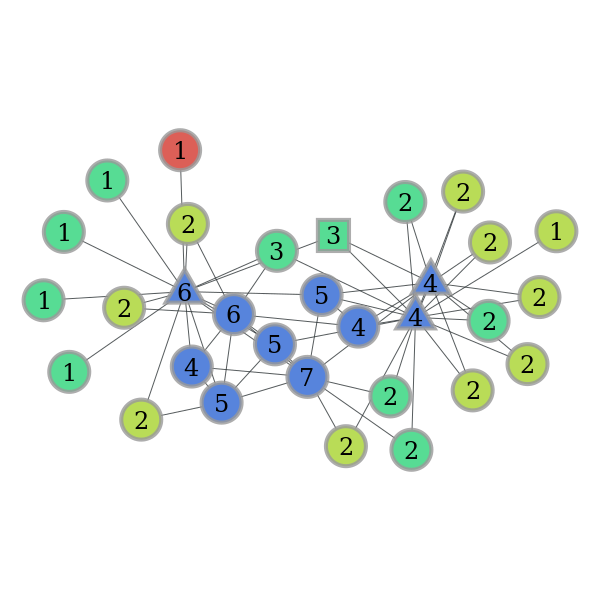

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbb58725b38, at 0x7fbb58aeca20>

In [74]:
color = get_color(subg, core)
shape = subg.new_vertex_property('int')
size = subg.new_vertex_property('int')
size.set_value(40)

target = 31
shape[target] = 2
size[target] = 44
for n in subg.vertex(target).out_neighbours():
    shape[n] = 1
    size[n] = 44
graph_draw(subg, pos, vertex_fill_color=color,
           vertex_text=deggt,
           edge_pen_width=1,
           vertex_font_size=font_size,
           vertex_size=size, 
           vertex_shape=shape,
           output='figs/karate-optimal-solution-degree-gt.png')

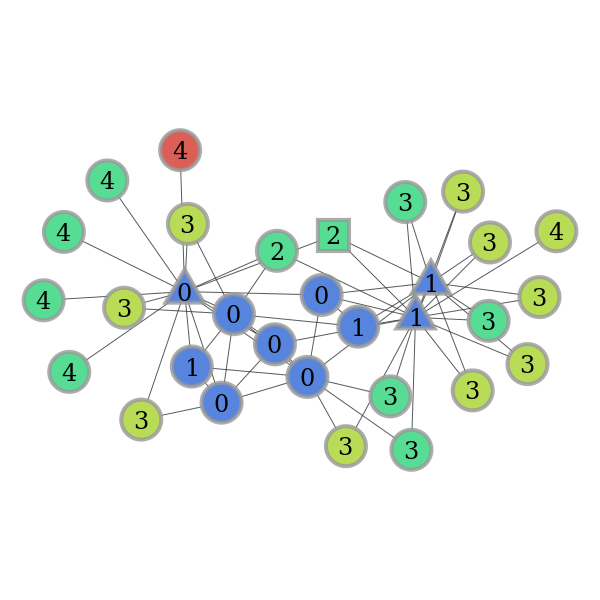

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fbb58725b38, at 0x7fbb58aeca20>

In [73]:
color = get_color(subg, core)
shape = subg.new_vertex_property('int')
size = subg.new_vertex_property('int')
size.set_value(40)

target = 31
shape[target] = 2
size[target] = 44
for n in subg.vertex(target).out_neighbours():
    shape[n] = 1
    size[n] = 44
graph_draw(subg, pos, vertex_fill_color=color,
           vertex_text=needed_num_edges,
           edge_pen_width=1,
           vertex_font_size=font_size,
           vertex_size=size, 
           vertex_shape=shape,
           output='figs/karate-optimal-solution-dive-in.png')